<a href="https://colab.research.google.com/github/fran0324/Neuro-240-Project/blob/main/SegFormer_(ViT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers timm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import os, re
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from google.colab import drive
drive.mount('/content/drive')
images_root =  '/content/drive/MyDrive/HVD_dataset/all_openrooms/main_xml'
labels_root =  '/content/drive/MyDrive/HVD_dataset/all_openrooms/labels_main_xml'

Mounted at /content/drive


In [4]:
def create_image_label_mapping(images_root, labels_root, max_samples=750):
    mapping = []
    for folder in os.listdir(images_root):
        img_folder = os.path.join(images_root, folder)
        label_folder = os.path.join(labels_root, folder)
        if not os.path.isdir(img_folder) or not os.path.isdir(label_folder):
            continue
        for fname in os.listdir(img_folder):
            if fname.endswith(".png") and fname.startswith("im_"):
                match = re.match(r'im_(\d+)\.png', fname)
                if match:
                    img_id = match.group(1)
                    img_path = os.path.join(img_folder, fname)
                    label_path = os.path.join(label_folder, f"imsemLabel_{img_id}.npy")
                    if os.path.exists(label_path):
                        mapping.append((img_path, label_path))
                        if len(mapping) >= max_samples:
                            return mapping
    return mapping

mapping = create_image_label_mapping(images_root, labels_root)
print("Samples loaded:", len(mapping))


Samples loaded: 750


In [5]:
def detect_num_classes(mapping):
    classes = set()
    for _, lbl_path in mapping:
        classes.update(np.unique(np.load(lbl_path)))
    return max(classes) + 1

num_classes = detect_num_classes(mapping)
print("Detected", num_classes, "classes")


Detected 46 classes


In [6]:
class SegformerTrainDataset(Dataset):
    def __init__(self, mapping, extractor, size=(128,128), augment=False):
        self.mapping   = mapping
        self.extractor = extractor
        self.size      = size
        self.augment   = augment

    def __len__(self):
        return len(self.mapping)

    def __getitem__(self, idx):
        img_path, lbl_path = self.mapping[idx]
        image = Image.open(img_path).convert("RGB")
        mask  = Image.fromarray(np.load(lbl_path).astype(np.uint8))

        image = image.resize(self.size, Image.BILINEAR)
        mask  = mask .resize(self.size, Image.NEAREST)
        # (optional augment here)...

        enc = self.extractor(images=image, return_tensors="pt", size=self.size)
        pixel_values = enc["pixel_values"].squeeze(0)      # tensor
        label        = torch.from_numpy(np.array(mask)).long()  # tensor

        return pixel_values, label



In [7]:
class SegformerDataset(Dataset):
    def __init__(self, mapping, extractor, size=(128, 128)):
        self.mapping = mapping
        self.extractor = extractor
        self.size = size

    def __len__(self):
        return len(self.mapping)

    def __getitem__(self, idx):
        img_path, lbl_path = self.mapping[idx]
        image = Image.open(img_path).convert("RGB")
        label = np.load(lbl_path).astype(np.uint8)
        label = Image.fromarray(label).resize(self.size, Image.NEAREST)

        label = torch.from_numpy(np.array(label)).long()
        inputs = self.extractor(images=image, return_tensors="pt", size=self.size)
        return inputs["pixel_values"].squeeze(), label


In [8]:
extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=num_classes,
    ignore_mismatched_sizes=True
).to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([46]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([46, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
dataset = SegformerDataset(mapping, extractor, size=(128, 128))

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1)


In [10]:
def evaluate(model, val_loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(pixel_values=x).logits
            out = F.interpolate(out, size=y.shape[-2:], mode='bilinear', align_corners=False)
            loss = criterion(out, y)
            total_loss += loss.item()
            preds = out.argmax(1)
            correct += (preds == y).sum().item()
            total += y.numel()
    avg_loss = total_loss / len(val_loader)
    avg_acc = 100 * correct / total
    return avg_loss, avg_acc


In [11]:
def train(model, train_loader, val_loader, epochs=5):
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            out = model(pixel_values=x).logits
            out = F.interpolate(out, size=y.shape[-2:], mode='bilinear', align_corners=False)
            loss = criterion(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = out.argmax(1)
            correct += (preds == y).sum().item()
            total += y.numel()

        train_loss = total_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Evaluation
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    return train_losses, train_accs, val_losses, val_accs



In [12]:
def plot_metrics(train_losses, train_accs, val_losses, val_accs):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Val Loss', marker='o')
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Acc', marker='o')
    plt.plot(epochs, val_accs, label='Val Acc', marker='o')
    plt.title("Pixel Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1 | Train Loss: 2.3747, Acc: 50.16% | Val Loss: 1.4615, Acc: 61.36%
Epoch 2 | Train Loss: 1.5183, Acc: 60.63% | Val Loss: 1.1858, Acc: 66.37%
Epoch 3 | Train Loss: 1.2325, Acc: 67.01% | Val Loss: 1.0306, Acc: 69.68%
Epoch 4 | Train Loss: 1.0368, Acc: 72.50% | Val Loss: 0.9296, Acc: 72.96%
Epoch 5 | Train Loss: 0.8955, Acc: 77.09% | Val Loss: 0.8732, Acc: 73.72%
Epoch 6 | Train Loss: 0.7665, Acc: 81.05% | Val Loss: 0.8311, Acc: 75.69%
Epoch 7 | Train Loss: 0.6709, Acc: 83.25% | Val Loss: 0.8497, Acc: 76.09%
Epoch 8 | Train Loss: 0.5965, Acc: 84.74% | Val Loss: 0.8381, Acc: 76.38%
Epoch 9 | Train Loss: 0.5212, Acc: 86.46% | Val Loss: 0.8252, Acc: 76.98%
Epoch 10 | Train Loss: 0.4693, Acc: 87.49% | Val Loss: 0.7529, Acc: 78.24%
Epoch 11 | Train Loss: 0.4365, Acc: 88.10% | Val Loss: 0.7814, Acc: 77.38%
Epoch 12 | Train Loss: 0.3961, Acc: 89.10% | Val Loss: 0.8348, Acc: 76.91%
Epoch 13 | Train Loss: 0.3640, Acc: 89.73% | Val Loss: 0.7544, Acc: 78.40%
Epoch 14 | Train Loss: 0.3524, Acc

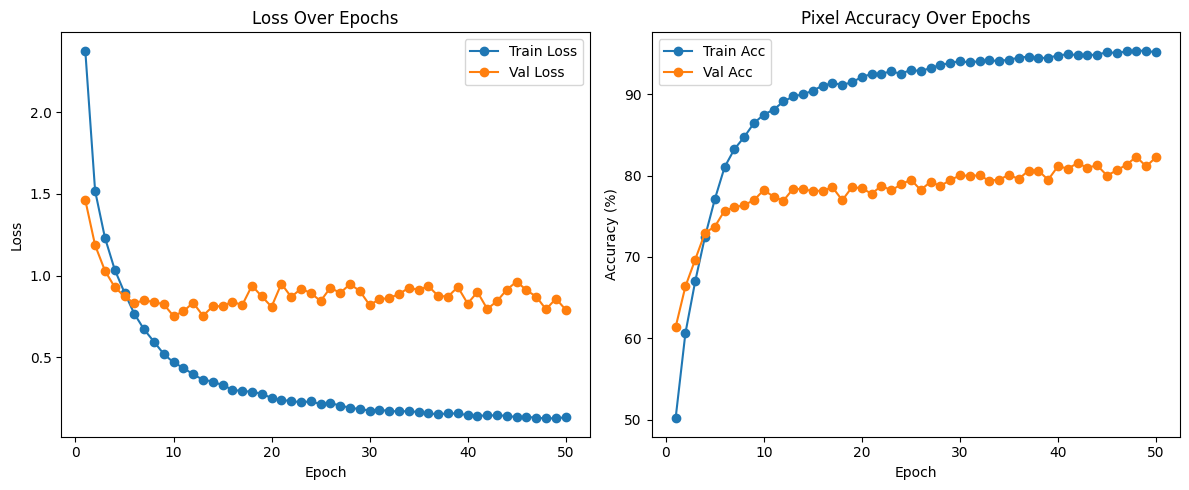

In [13]:
train_losses, train_accs, val_losses, val_accs = train(model, train_loader, val_loader, epochs=50)
plot_metrics(train_losses, train_accs, val_losses, val_accs)


In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import colorsys

def visualize_predictions(model, dataset, class_names, num_samples=3, device='cuda'):
    model.eval()  # set model to evaluation mode
    # --- Create distinct color map for all classes ---
    N = len(class_names)
    colors = []
    for j in range(N):
        # generate color j by evenly spaced hue on [0,1)
        h = j / N
        l, s = 0.6, 0.9  # lightness and saturation for all colors
        rgb = colorsys.hls_to_rgb(h, l, s)
        colors.append(rgb)
    custom_cmap = ListedColormap(colors)

    # --- Display results for a few samples ---
    for i in range(num_samples):
        image, true_mask = dataset[i]
        # Run model prediction
        with torch.no_grad():
            input_tensor = image.unsqueeze(0).to(device)
            output = model(input_tensor)
            # If model outputs a structure with logits (e.g. from HuggingFace), handle that:
            logits = output.logits if hasattr(output, 'logits') else output
            pred_mask = torch.argmax(logits.squeeze(0), dim=0).cpu().numpy()
        # Prepare numpy image for plotting
        img_np = image.permute(1, 2, 0).cpu().numpy()

        # Plot four panels
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        # (a) Input image
        axes[0].imshow(img_np)
        axes[0].set_title("Input Image")
        axes[0].axis('off')
        # (b) Ground truth mask
        axes[1].imshow(true_mask.numpy(), cmap=custom_cmap)
        axes[1].set_title("Ground Truth")
        axes[1].axis('off')
        # (c) Prediction mask
        axes[2].imshow(pred_mask, cmap=custom_cmap)
        axes[2].set_title("Prediction Mask")
        axes[2].axis('off')
        # (d) Overlay of prediction on input
        axes[3].imshow(img_np)
        axes[3].imshow(pred_mask, cmap=custom_cmap, alpha=0.5)
        axes[3].set_title("Overlay on Input")
        axes[3].axis('off')

        # Optional: add a legend mapping class names to colors (for reference)
        handles = [mpatches.Patch(color=colors[j], label=class_names[j]) for j in range(N)]
        fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.05),
                   ncol=6, fontsize='small', frameon=False)
        plt.tight_layout()
        plt.show()


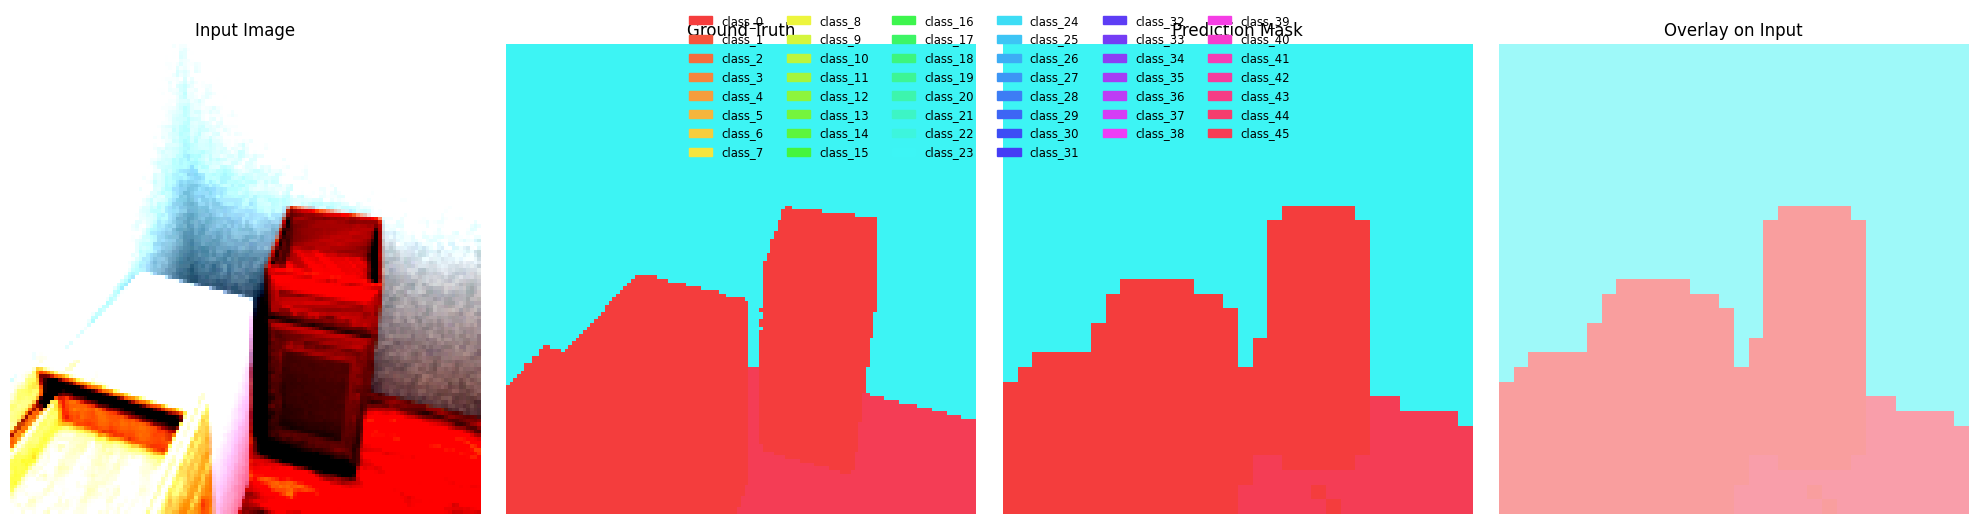

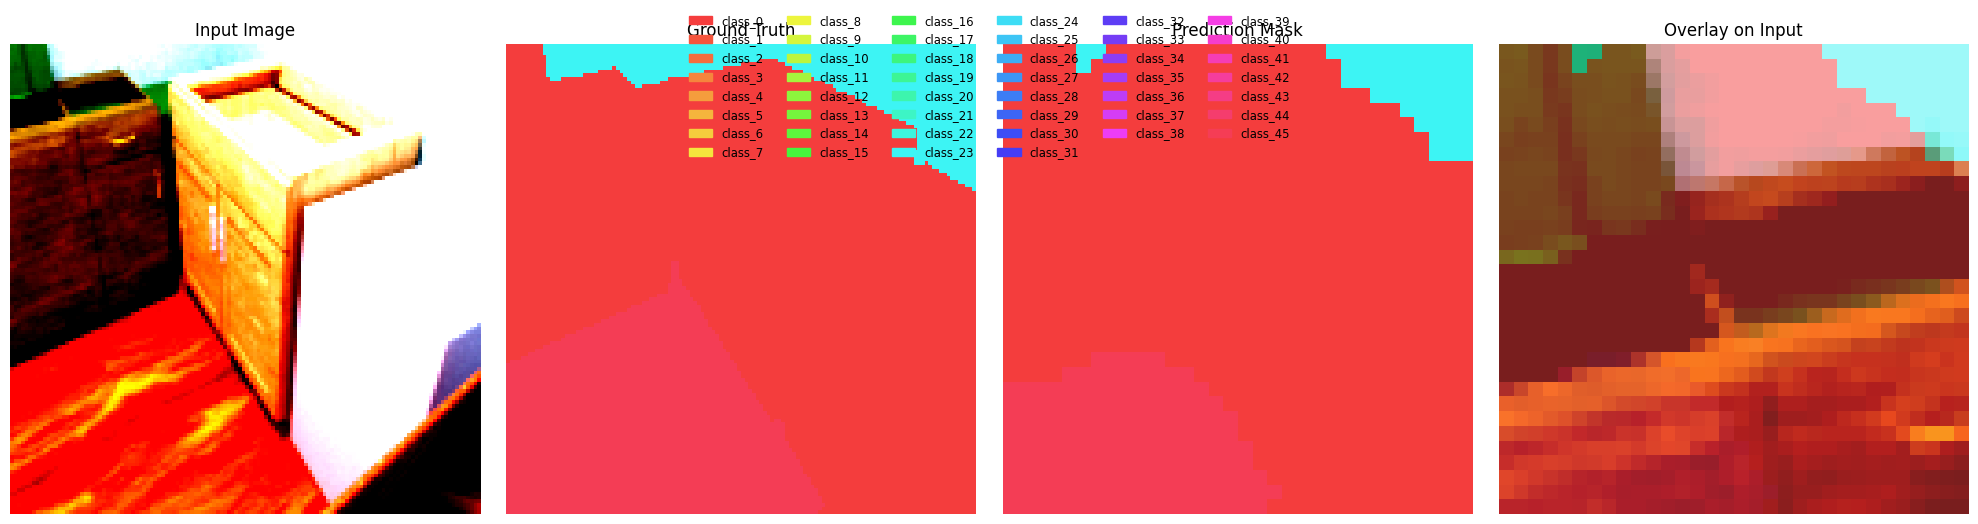

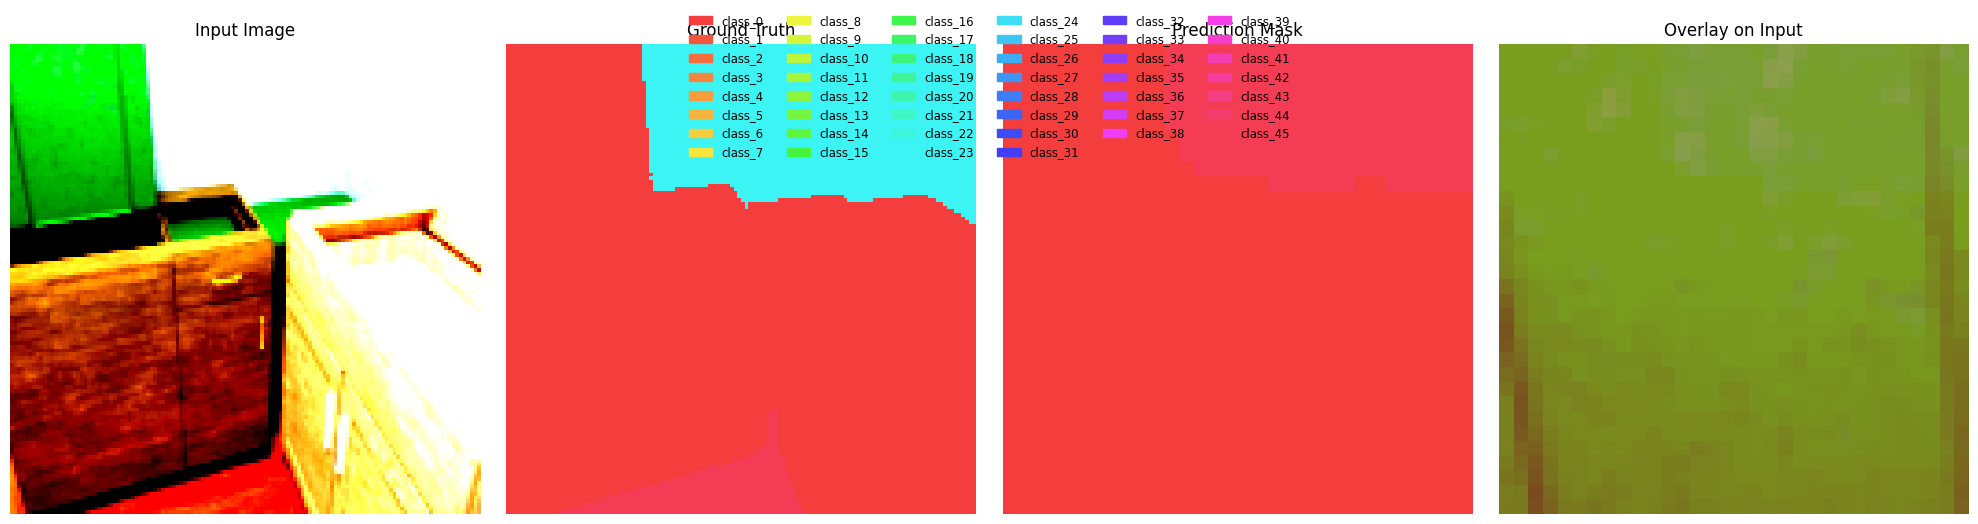

In [15]:
class_names = [f"class_{i}" for i in range(num_classes)]

visualize_predictions(model, dataset, class_names, num_samples=3, device=device)



In [19]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_class_attention(model, feature_extractor, image_pil, class_ids):
    """
    Visualize the transformer attention heatmaps for specified class_ids on the given image.

    - model: SegformerForSemanticSegmentation (in eval mode; should already be on the desired device)
    - feature_extractor: corresponding feature extractor (for preprocessing)
    - image_pil: input image as PIL image
    - class_ids: list of class indices to visualize attention for
    """
    model.eval()

    # Figure out where the model lives (CPU or GPU) and move inputs there:
    device = next(model.parameters()).device

    # Preprocess and move inputs to same device:
    inputs = feature_extractor(images=image_pil, return_tensors="pt")
    pixel_values = inputs["pixel_values"].to(device)   # <-- FIX: .to(device)

    # Forward pass (ask for attentions)
    outputs = model(pixel_values=pixel_values, output_attentions=True)
    logits = outputs.logits   # shape (1, num_classes, h, w)
    attentions = outputs.attentions

    # Upsample logits back to image size
    logits_up = torch.nn.functional.interpolate(
        logits,
        size=image_pil.size[::-1],  # (H, W)
        mode='bilinear',
        align_corners=False
    )
    pred_mask = logits_up.argmax(dim=1).squeeze().cpu().numpy()  # bring mask back to CPU

    # Use last encoder layer’s attention
    # attentions[-1]: (1, num_heads, N, N)
    attn = attentions[-1].mean(dim=1).squeeze(0).cpu().detach().numpy()  # shape (N, N)

    # Figure out patch grid
    N = attn.shape[0]
    patch_grid = int(np.sqrt(N))
    img_h, img_w = pred_mask.shape
    patch_h, patch_w = img_h // patch_grid, img_w // patch_grid

    # Prepare plotting
    fig, axes = plt.subplots(1, len(class_ids), figsize=(5 * len(class_ids), 5))
    if len(class_ids) == 1:
        axes = [axes]

    for ax, class_id in zip(axes, class_ids):
        attn_map = np.zeros(N)
        # accumulate attention from patches where the predicted class dominates
        for patch_idx in range(N):
            row, col = divmod(patch_idx, patch_grid)
            y0, y1 = row * patch_h, (row + 1) * patch_h
            x0, x1 = col * patch_w, (col + 1) * patch_w
            patch_mask = pred_mask[y0:y1, x0:x1]

            if (patch_mask == class_id).mean() > 0.5:
                attn_map += attn[patch_idx]

        # normalize (avoid division by zero)
        if attn_map.max() > 0:
            attn_map = attn_map / attn_map.max()

        # reshape back to grid and upscale to pixel resolution
        attn_grid = attn_map.reshape(patch_grid, patch_grid)
        attn_heatmap = np.kron(attn_grid, np.ones((patch_h, patch_w)))

        # overlay
        ax.imshow(image_pil)
        ax.imshow(attn_heatmap, cmap='jet', alpha=0.4)
        ax.set_title(f"Attention for class {class_id}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()



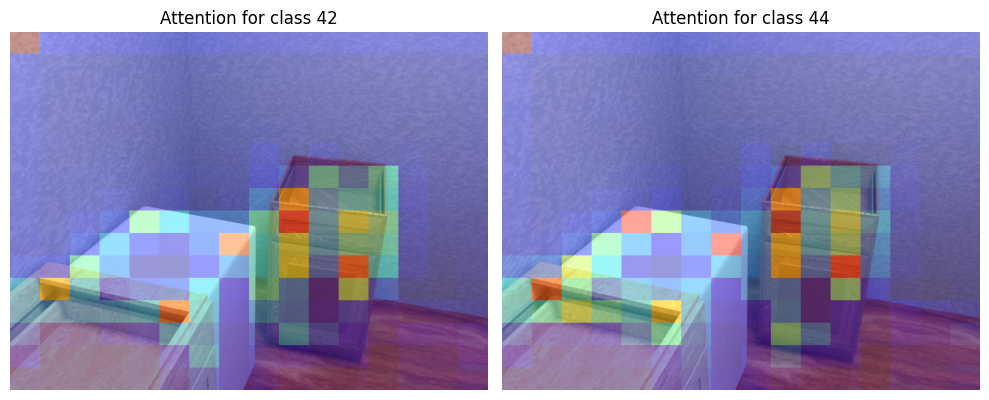

In [24]:
# Example usage on a test image:
test_image, true_mask = dataset[1]  # get first sample (here dataset returns (pixel_values, label))
# We need the original PIL image; if dataset returns pixel_values, we should load via mapping
from PIL import Image
img_path, _ = mapping[0]
test_image_pil = Image.open(img_path).convert("RGB")
visualize_class_attention(model, extractor, test_image_pil, class_ids=[42, 44])  # visualize for classes 42 and 45 as examples: 42 is for "cabinet" 44 is for "floor"